<a href="https://colab.research.google.com/github/sanam2226/Song-Popularity-Analysis-Prediction/blob/main/Statistical_Analysis_of_Song_Popularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra

#Objective#
In the below analysis you will find some detailed EDA on what makes a song popular and hypothesis testing for giving any sort of inference from a Statistical point of view. The objective of conducting this analysis was to build a robust model to predict the popularity of a song based on several attributes like energy, acoustics, tempo, liveness, danceability, as well as to understand how these features impact it.

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import os


In [ ]:
audiodf = pd.read_csv("/content/drive/MyDrive/Song Popularity Analysis/data/SpotifySongPolularityAPIExtract.csv")
print(audiodf.describe())
print(audiodf.head())

        acousticness   danceability   duration_ms         energy  \
count  130663.000000  130663.000000  1.306630e+05  130663.000000   
mean        0.342500       0.581468  2.126331e+05       0.569196   
std         0.345641       0.190077  1.231551e+05       0.260312   
min         0.000000       0.000000  3.203000e+03       0.000000   
25%         0.031600       0.459000  1.639225e+05       0.396000   
50%         0.203000       0.605000  2.019010e+05       0.603000   
75%         0.636000       0.727000  2.410475e+05       0.775000   
max         0.996000       0.996000  5.610020e+06       1.000000   

       instrumentalness            key       liveness       loudness  \
count     130663.000000  130663.000000  130663.000000  130663.000000   
mean           0.224018       5.231894       0.194886      -9.974006   
std            0.360328       3.602701       0.167733       6.544379   
min            0.000000       0.000000       0.000000     -60.000000   
25%            0.000000    

##Loading Required Packages##

In [ ]:

import math
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
from IPython.display import display
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")
import gc
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats  as stats

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

!pip3 install catboost
from catboost import CatBoostRegressor, Pool


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.0 MB/s eta 0:00:00


Type *Markdown* and LaTex: a2

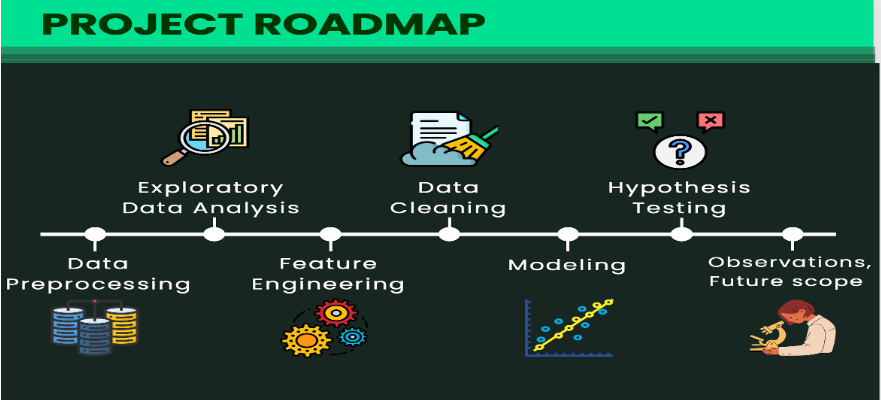

In [ ]:
from sqlalchemy.engine.interfaces import ReflectedUniqueConstraint
# Function to check the missing value count and percentages
def mising_val_check(data):
  """
  Import data that we have created as a DataFrame
  Output: Missing value report by columns
  """

  # Missing data check
  total = data.isnull().sum().sort_values(ascending=False)
  percent = (data.isnull().sum() / data.isnull().count()
            ).sort_values(ascending=False)
  missing_data = pd.concat(
      [total, percent * 100], axis=1, keys=["Total","Percent(%)"]
    )
  return missing_data

def get_box_plot(train):
  cont_cols = list(train._get_numeric_data().columns)
  fig, ax = plt.subplots(nrows=len(cont_cols) //2 +
                         1, ncols=2, figsize=(10,10))
  
  def func(x): return x.replace("_"," ").capitalize()
  cols_corrected = list(map(func, cont_cols))

  var_idx = 0

  for i in range(len(cont_cols) // 2 +1):
    for j in range(2):
      try:
        sns.boxplot(train[cont_cols[var_idx]],
                    ax=ax[i][j], color="red")
        ax=ax[i][j].set_xlabel(cols_corrected[var_idx])
        var_idx +=1
      except:
        break
  
  fig.suptitle("Box plots for outliers")

##Data Pre-Processing##

**Let's load the dataset**

In [ ]:
audiodf = pd.read_csv("/content/drive/MyDrive/Song Popularity Analysis/data/SpotifySongPolularityAPIExtract.csv")
# Creating a duration feature converted to minutes for intuitive understanding

audiodf["duration_ms"] = audiodf["duration_ms"] / 60000
audiodf = audiodf.rename(columns = {"duration_ms":"duration_mins"})
# audiodf.drop(["duration_ms"],axis=1, inplace=True)

print(audiodf.shape)
print(audiodf.columns)

(130663, 17)
Index(['artist_name', 'track_id', 'track_name', 'acousticness', 'danceability',
       'duration_mins', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'popularity'],
      dtype='object')


In [ ]:
audiodf.head(5).T

,0,1,2,3,4
artist_name,YG,YG,R3HAB,Chris Cooq,Chris Cooq
track_id,2RM4jf1Xa9zPgMGRDiht8O,1tHDG53xJNGsItRA3vfVgs,6Wosx2euFPMT14UXiWudMy,3J2Jpw61sO7l6Hc7qdYV91,2jbYvQCyPgX3CdmAzeVeuS
track_name,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",BAND DRUM (feat. A$AP Rocky),Radio Silence,Lactose,Same - Original mix
acousticness,0.00582,0.0244,0.025,0.0294,0.000035
danceability,0.743,0.846,0.603,0.8,0.783
duration_mins,3.972883,3.58,2.315217,2.089683,2.066933
energy,0.339,0.557,0.723,0.579,0.792
instrumentalness,0.0,0.0,0.0,0.912,0.878
key,1,8,9,5,7
liveness,0.0812,0.286,0.0824,0.0994,0.0332


In [ ]:
print("Total Duplicates on the basis of tracks in the data", audiodf[audiodf.duplicated(subset="track_id")].shape[0])

Total Duplicates on the basis of tracks in the data 337


In [ ]:
len(audiodf)

130663

In [ ]:
audiodf.describe([.1,.25, .5, .75, .9, .99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
acousticness,130663.0,0.342500,0.345641,0.000000,0.002440,0.031600,0.203000,0.636000,0.93000,0.994000,0.996000
danceability,130663.0,0.581468,0.190077,0.000000,0.310000,0.459000,0.605000,0.727000,0.80900,0.919000,0.996000
duration_mins,130663.0,3.543885,2.052584,0.053383,1.912167,2.732042,3.365017,4.017458,4.98717,9.539393,93.500333
energy,130663.0,0.569196,0.260312,0.000000,0.163000,0.396000,0.603000,0.775000,0.89400,0.987000,1.000000
instrumentalness,130663.0,0.224018,0.360328,0.000000,0.000000,0.000000,0.000149,0.440000,0.89300,0.969000,1.000000
key,130663.0,5.231894,3.602701,0.000000,0.000000,2.000000,5.000000,8.000000,10.00000,11.000000,11.000000
liveness,130663.0,0.194886,0.167733,0.000000,0.076200,0.097500,0.124000,0.236000,0.38300,0.895000,0.999000
loudness,130663.0,-9.974006,6.544379,-60.000000,-19.276000,-11.898000,-7.979000,-5.684000,-4.20900,-2.082000,1.806000
mode,130663.0,0.607739,0.488256,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000
speechiness,130663.0,0.112015,0.124327,0.000000,0.032000,0.038900,0.055900,0.129000,0.29400,0.553000,0.966000


**Remark:**

The stats look fine however some of features that might contain outliers needs to be taken care of

1. Majority of songs have a duration of 3.36 mins however some of the songs have the duration greater than 10 mins which needs to be treated. We can see the 99th percentile value to be close to 9.54 minutes. Lets remove all the songs greater than 10 mins of duration.

2. In some songs, tempo, time_signature is 0 which is not possible hence a potential anomoly in the data, hence such value will add noise to our model. We will be taking all songs with tempo & time_signature > 0

3. In some songs, duration is < 1 min. As per our research songs have minimum duration of 1 mins else its not a song it is an abstract of the same. In addition some songs are greater than 10 mins of duration. As per our research we tried to search and found that some songs in the data are pure noise or podcasts which is out of scope for this analysis. Hence we will remove the songs with < 1min of duration and greater than 10 mins of duration. 10 mins taken from 99 percentile of data split.

4. We also observer some songs to have 0 popularity. The count is roughly around 13k songs. Hence to reduce biasness we can remove these songs from our data.

5. songs which have liveliness over 0.8 are mostly live performances hence it should be removed.

6. We see that there is no key with value of -1. This means that all tracks that we have, contain a well-detected key value.




In [ ]:
class Data_Preprocessing_SP(object):
  def __init__(self, data = None, subset_on = None, keep="first", song_duration_min_cutoff = 1, song_duration_max_cutoff = 10, speechiness_cutoff = 0.66, liveness_cutoff = 0.8):
    self.data = data
    self.subset_on = subset_on
    self.keep = keep
    self.song_duration_min_cutoff = song_duration_min_cutoff
    self.song_duration_max_cutoff = song_duration_max_cutoff
    self.speechiness_cutoff = speechiness_cutoff
    self.liveness_cutoff = liveness_cutoff

  def duplicate_removals(self):
    """
    Removes duplicates on a primary key given
    """
    print("\n1. Duplicate Data Check & Removal if any")
    print("\nTotal duplicatesd on {} level are {}".format(self.subset_on, self.data[self.data.duplicated(subset = "track_id")].shape[0]))

    self.data = self.data.drop_duplicates(subset = ["track_id"], keep = self.keep).reset_index(drop = True)
    print("\nTotal duplicatesd on {} level post treatment: {}".format(self.subset_on, self.data[self.data.duplicated(subset = "track_id")].shape[0]))
    print("\nDuplicate Data treated")
    return self.data
  

  def intuitive_outlier_removal(self):
    print("\n2. Outlier removing engine started")

    print("\nRemoving outliers in duration (mins) of songs")
    self.data = self.data.query(f" duration_mins>={self.song_duration_min_cutoff} and duration_mins<={self.song_duration_max_cutoff}")

    print("\nRemoving songs with 0 tempo and time signature and songs with 0 popularity")
    self.data = self.data.query(f"tempo>0 and time_signature>0 and popularity>0")

    print("\nRemoving songs with speechiness over 0.66")
    self.data = self.data.query(f"speechiness<{self.speechiness_cutoff}")

    print("\nRemoving songs with liveness less than 0.8")
    self.data = self.data.query(f"liveness<{self.liveness_cutoff}")

    print("\nIntuitive outliers removed")
    return self.data

  def runner(self):
    print("=====Data Preprocessing on Song Populatity Data started=====")
    self.data = self.duplicate_removals()
    self.data = self.intuitive_outlier_removal()
    print("\n=====Data Preprocessing on Song Popularity Data completed====")
    return self.data



In [ ]:
audiodf=Data_Preprocessing_SP(
    data=audiodf,
    subset_on="track_id",
    keep="first",
    song_duration_min_cutoff=1,
    song_duration_max_cutoff=10,
    speechiness_cutoff=0.66
).runner()

=====Data Preprocessing on Song Populatity Data started=====

1. Duplicate Data Check & Removal if any

Total duplicatesd on track_id level are 337

Total duplicatesd on track_id level post treatment: 0

Duplicate Data treated

2. Outlier removing engine started

Removing outliers in duration (mins) of songs

Removing songs with 0 tempo and time signature and songs with 0 popularity

Removing songs with speechiness over 0.66

Removing songs with liveness less than 0.8

Intuitive outliers removed

=====Data Preprocessing on Song Popularity Data completed====


In [ ]:
audiodf.describe(include = ['O']).T


,count,unique,top,freq
artist_name,105460,29292,Johann Sebastian Bach,2900
track_id,105460,105460,2RM4jf1Xa9zPgMGRDiht8O,1
track_name,105460,88818,Intro,62


In [ ]:
audiodf.describe([.1,.25, .5, .75, .9, .99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
acousticness,105460.0,0.337596,0.343539,0.00000,0.002640,0.031600,0.196000,0.622000,0.926000,0.994000,0.996
danceability,105460.0,0.584031,0.186020,0.05130,0.320000,0.462000,0.606000,0.726000,0.808000,0.918000,0.996
duration_mins,105460.0,3.551963,1.248955,1.00000,2.197132,2.851117,3.409083,4.033333,4.940543,8.117774,10.000
energy,105460.0,0.573054,0.257334,0.00002,0.172000,0.404000,0.609000,0.777000,0.892000,0.982000,1.000
instrumentalness,105460.0,0.201460,0.345517,0.00000,0.000000,0.000000,0.000090,0.253000,0.882000,0.962000,1.000
key,105460.0,5.231728,3.599081,0.00000,0.000000,2.000000,5.000000,8.000000,10.000000,11.000000,11.000
liveness,105460.0,0.179479,0.136007,0.01130,0.075900,0.096800,0.122000,0.219000,0.359000,0.700000,0.799
loudness,105460.0,-9.585276,6.337887,-55.90900,-18.520200,-11.308000,-7.633000,-5.518000,-4.128000,-2.120000,1.187
mode,105460.0,0.607747,0.488255,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000
speechiness,105460.0,0.105609,0.108810,0.02210,0.031900,0.038600,0.054900,0.122000,0.281000,0.483000,0.659


##Exploratory Data Analysis##

**Distribution of all numeric variables**

                                 Numeric Features Distribution                                  


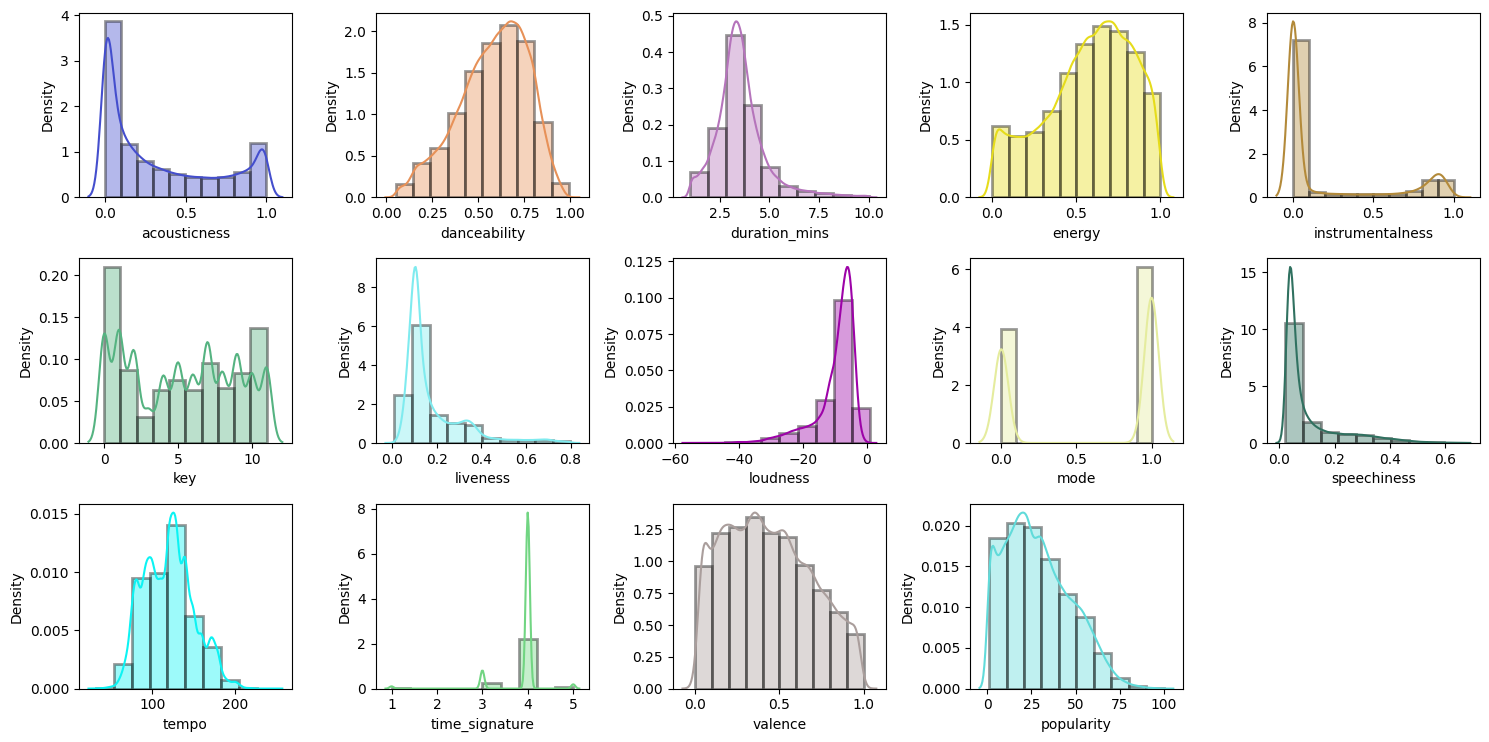

In [ ]:
from pandas.core.internals.blocks import np_can_hold_element
print('\033[1mNumeric Features Distribution'.center(100))

n = 5
cols = audiodf.columns.tolist()[3:]
n_col = len(cols)

clr=['r','g','b','g','b','r']

plt.figure(
    figsize=[15, 4*math.ceil(n_col/n)]
    )

for i in range(n_col):
  plt.subplot(math.ceil(n_col/3),n, i+1)
  sns.distplot(audiodf[cols[i]], hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))

  plt.tight_layout()
  plt.show




**Remark:**

We can observe from the above plots that,

1. ***Acousticness*** has values that range from 0.0 to 1.0, but most values lie near 0. The songs with high acousticness consist of classical or folk music.

2. ***Danceability*** has values from 0.0 to 1.0, and we see that most values lie around 0.7, with a small percent of values towards the extreme ends(0 and 1)

3. ***Duration_mins*** takes values from 1.0 to 10.0, and we can see that most songs range from 3 to 4 minutes.

4. ***Energy*** consists of values from 0.0 to 1.0, and we see that the density of songs with energy less than 0.5 is very less.

5. ***Instrumentalness*** has values from 0.0 to 1.0. This variable predicts if a song has vocals(Lower the value, higher the chance of vocals) and we see that, most songs have a value near 0, which means most songs have a presence of vocal component in them.

6. ***Key*** has values from 0 to 12, with values 0 for C and 12 for B.We can see that most songs are in the keys of C# and C

7. ***Liveness*** contains values from 0.0 to 1.0, with higher values meaning more chances of presence of audience in the recording. We see that most songs have a liveness near 0.0, and we will clean our data and remove songs, which can be live performances.

8. ***Loudness*** has values from 0.0 to 1.0, and we can see most songs have a loudness of around -10dB. Here 0dB is the normal standard for human hearing.

9. ***Mode*** has 2 values 0 and 1. We see that most songs have a happy tone in them, as they are in the major mode(mode=1), which is usually happy sounding

10. ***Speechiness*** has values from 0.0 to 1.0, and we can see that most songs have a speechiness of less than 0.25, also we clean out songs with speechiness of more than 0.66, as usually they would be podcasts, intro/outro tracks, and live performances.

11. ***Tempo*** mostly contains vales between 100 and 250, and we can see that the statistical mode for tempo is around 125, as people can enjoy the track rhythmically the most with the tempo around 120-130.

12. ***Time Signature*** contains values 1.0 to 5.0 and wee see that most songs have a value of 4.0, which is vital for a song to gain much fan following as it is a universal rhythmic pattern.

13. ***Valence*** has values from 0.0 to 1.0, and we can see that most songs have a valence of less than 0.5, which indices a lesser tone happiness in most songs. We can make sense out of this pattern as the most popular key-mode pair from above plots, C#major or Dbmajor, usually represant a tone of grief or sadness.

14. ***Popularity*** takes values from 0.0 to 100.0, and we can see that there are only a few number of songs which are very popular, and there are a lot of tracks which go unheard.

**Lets Plot the same for Top-20 Most Polular Songs:**

                                 Numeric Features Distribution                                  


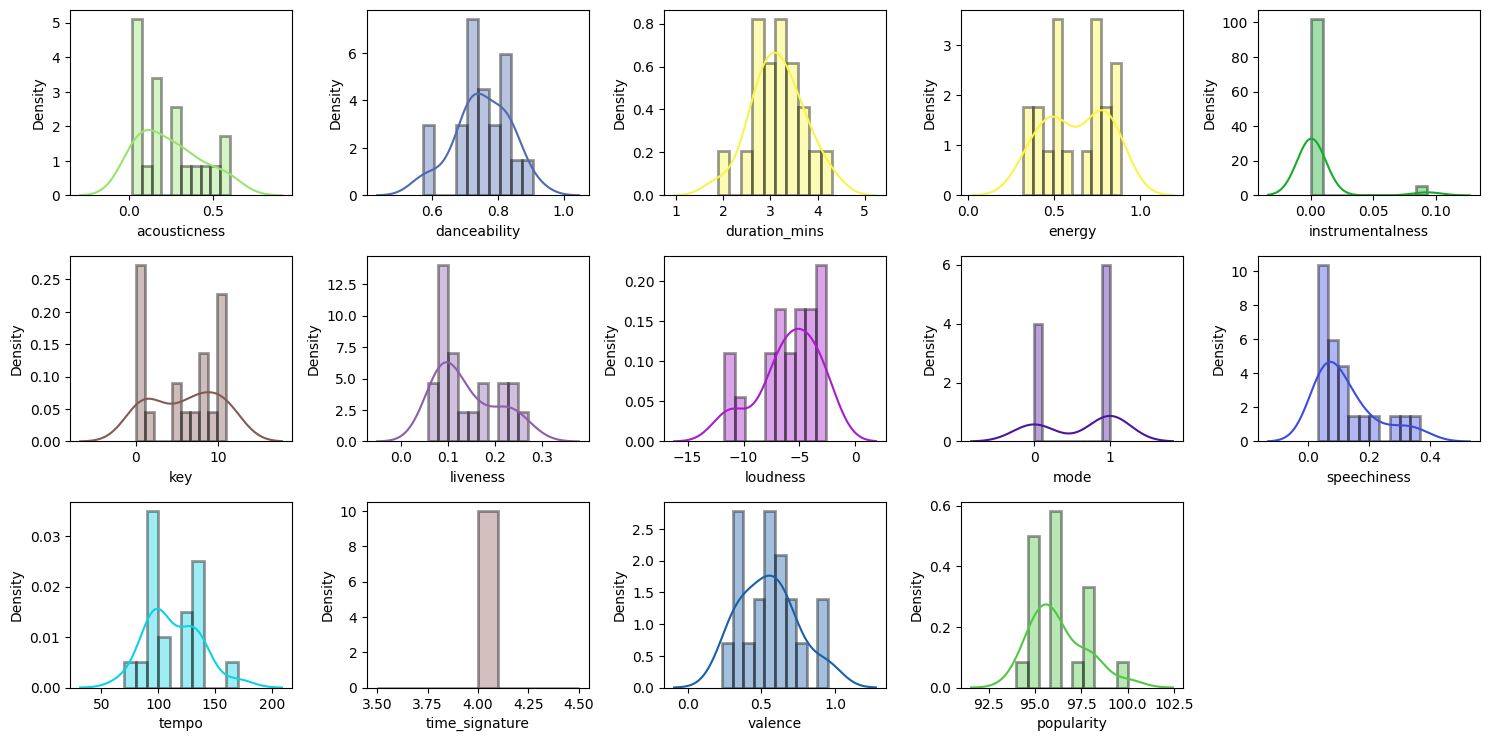

In [ ]:
top_20_songs = audiodf.sort_values('popularity', ascending = False).copy().head(20)

print('\033[1mNumeric Features Distribution'.center(100))

n = 5
cols = top_20_songs.columns.tolist()[3:]
n_col = len(cols)

clr=['r','g','b','g','b','r']

plt.figure(
    figsize=[15,4*math.ceil(n_col/n)])

for i in range(n_col):
    plt.subplot(math.ceil(n_col/3),n,i+1)
    sns.distplot(top_20_songs[cols[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))

plt.tight_layout()
plt.show()

**Remark**

We can see from the above data that the top popular songs have,

1. ***Time Signature:*** The same time signature of 4, people enjoy rhythmic patterns that they are used to, as 4 is the most universal time signature.

2. ***Instrumentalness:*** People tend to listen songs with instrumentalness of value around 0 i.e. people enjoy vocals/lyrical presence than instrumental presence.

3. ***Key:*** The most popular songs are seen for key are C,C#, G#, B. Intuitive this make sense as B major has a relative minor of G# minor and both modes sound alike.

4. ***Dancability:*** Most popular songs have dancability score of around 0.75-0.85. People listen to more hype music.

5. ***Loudness (in scale of log2):*** Popular songs tend to have loudness in the range of -7 to -2 while a normal song on average have loudness in the range of -10 to -5. Popular songs tend to have more compression than an average song.

6. ***Duration:*** Most popular songs have duration of close to 2.5 mins, this tend to mean that people have less attention span while listening to music or doing anything.

7. ***Valence:*** As opposed to an average song, majority of popular songs tend to be more happy sounding, i.e. having a valence of over 0.35, so we see that the most popular songs are usually happy-toned.

8. ***Accousticness:*** People generally tend to listen to highly electrical music as opposed to clean accoustic tones like classical piece.

9. ***Energy:*** High Energy genres like metal and EDM do not usually show up in popular music.

10. ***Liveness:*** People tend to listen more to clean and compressed songs in comparison to distorted audio.

11. ***Tempo:*** Most popular song tend to have tempo less than 150 and more concentrated towards 100.

Top 20 artist who have the highest average popularity amongst their songs:

In [ ]:
audiodf.groupby('artist_name')['popularity'].mean().sort_values(ascending = False).head(20)

artist_name
Jonas Brothers         91.000000
Don Patricio           86.000000
Guaynaa                84.000000
Rammstein              84.000000
Paloma Mami            82.333333
DJ Luian               81.333333
PDL                    81.000000
MC L da Vinte          81.000000
XO Cupid               81.000000
MC Kevin o Chris       81.000000
Louis Tomlinson        81.000000
Lil Dicky              81.000000
Lil Nas X              81.000000
Tame Impala            80.000000
Daddy Yankee           79.833333
I Belong to the Zoo    79.000000
Yo Gotti               79.000000
JENNIE                 79.000000
juan karlos            79.000000
K/DA                   79.000000
Name: popularity, dtype: float64

**Lets plot to see if we can find any pattern between highly, moderately and low popularity songs:**

<Axes: title={'center': 'Average Traits of Top-Moderately-Low popular Songs'}>

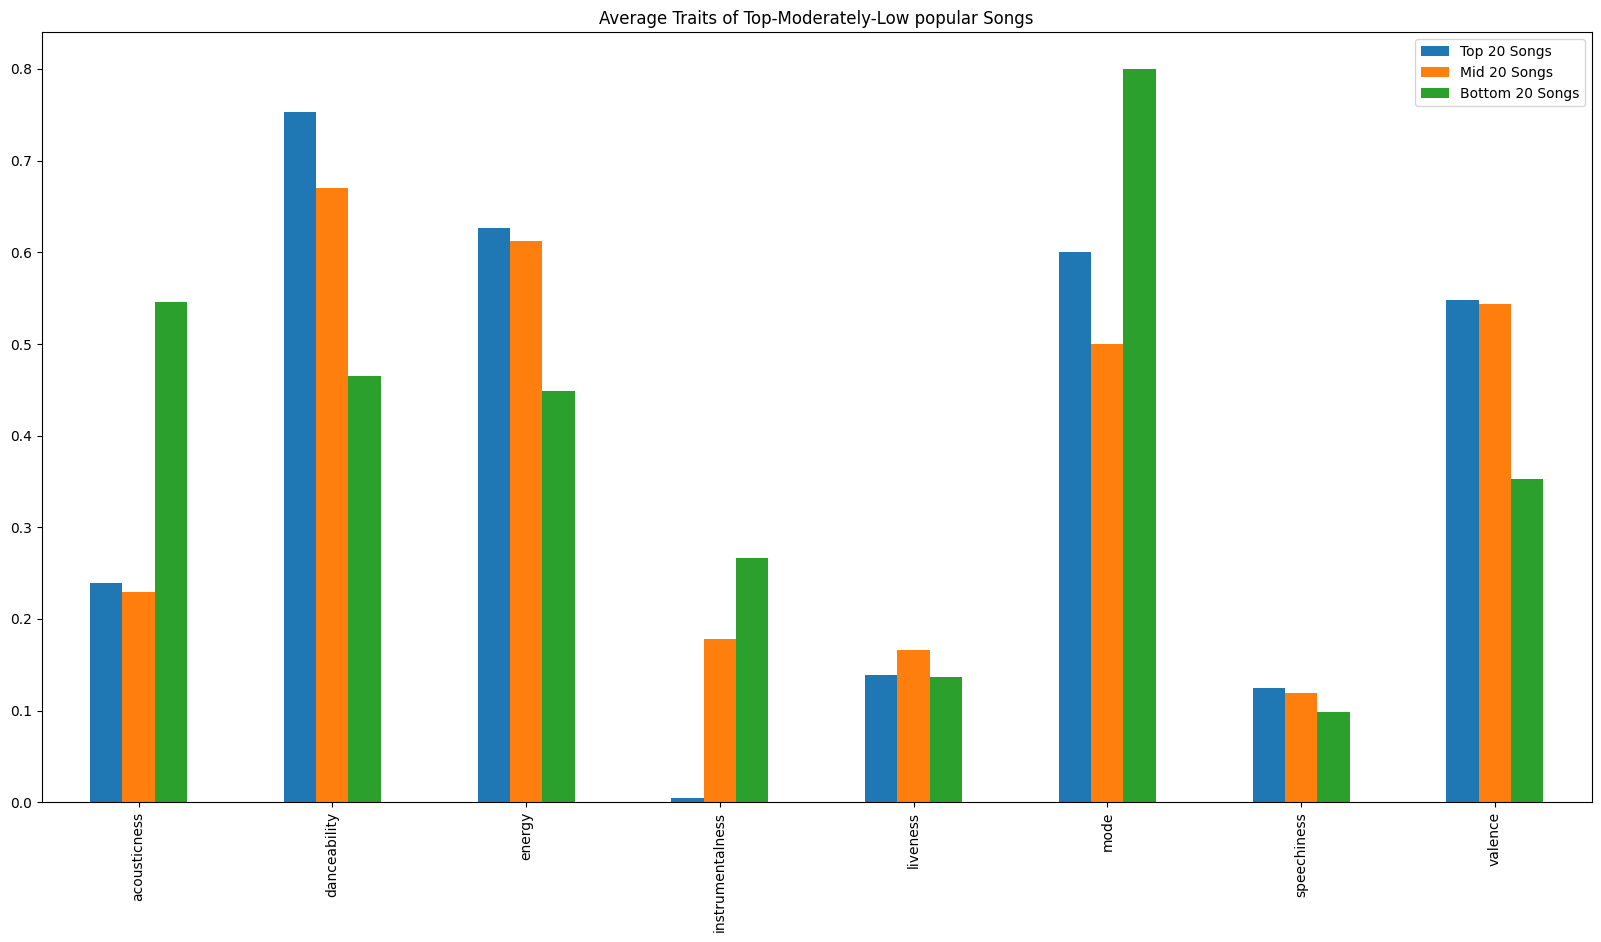

In [ ]:
# Top 20
check = audiodf.sort_values(by = 'popularity',ascending=False).head(20)[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']]
check = check.T
top_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Top 20 Songs'])

# Mid 20
check = audiodf[audiodf['popularity'].between(audiodf['popularity'].quantile(0.45),audiodf['popularity'].quantile(0.55))]
check = check[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']].head(20)
check = check.T
mid_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Mid 20 Songs'])

# Bottom 20
check = audiodf.sort_values(by = 'popularity',ascending=False).tail(20)[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']]
check = check.T
bottom_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Bottom 20 Songs'])

top_bottom = pd.concat([top_20,mid_20, bottom_20], axis = 1)

top_bottom.plot(title = 'Average Traits of Top-Moderately-Low popular Songs', figsize=(20,10),linewidth=2,kind = 'bar' )

***Lets compare numeric features between Top-10% most popular songs vs average-10% songs:***

                  top10percentile  avg10percentile
acousticness                0.995           0.9910
danceability                0.715           0.6570
duration_mins               3.200           3.2000
energy                      0.579           0.8180
instrumentalness            0.000           0.0000
key                         1.000           1.0000
liveness                    0.111           0.1090
loudness                   -6.365          -5.5490
mode                        1.000           1.0000
speechiness                 0.040           0.0351
tempo                     100.003         129.9950
time_signature              4.000           4.0000
valence                     0.325           0.9620
Axes(0.125,0.11;0.775x0.77)


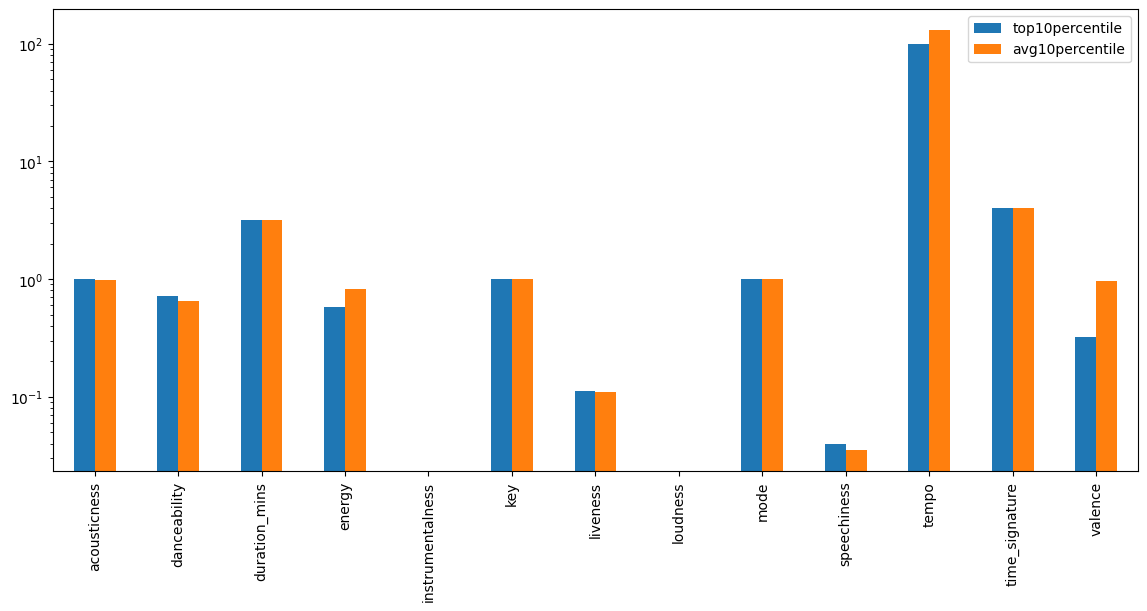

In [ ]:
top10 = np.percentile(audiodf.popularity.tolist(),90)
avg10low = np.percentile(audiodf.popularity.tolist(),45)
avg10high = np.percentile(audiodf.popularity.tolist(),55)

topdf = audiodf[audiodf.popularity>=top10].iloc[:,3:-1]
avgdf = audiodf[audiodf.popularity>=avg10low][audiodf.popularity<=avg10high].iloc[:,3:-1]

topdf = topdf.mode(axis = 0).iloc[0,:]
avgdf = avgdf.mode(axis = 0).iloc[0,:]

compdf = pd.concat([topdf,avgdf],axis = 1)
compdf.columns = ['top10percentile','avg10percentile']

print(compdf)

print(
    compdf.plot(
    kind="bar",
    logy = True,
    figsize = (14,6)
    )
)

*Correlation Matrix:*

<Axes: >

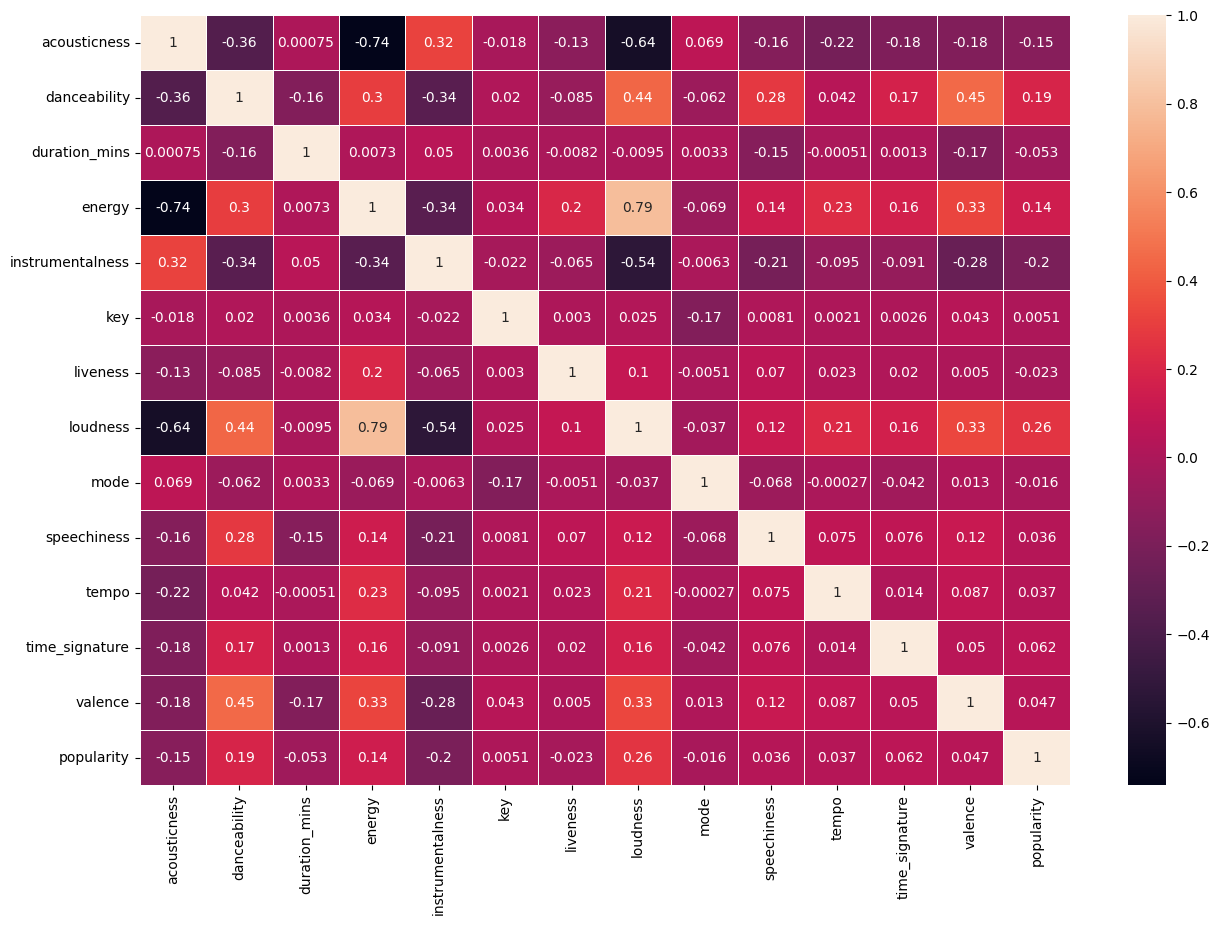

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))      
sns.heatmap(audiodf.corr(), annot=True,linewidths=.5, ax=ax)

**Remark:**

We can observe that loudness is highly correlated with energy, instrumentalness and acousticness. Thus, We are removing loudness feature from the data

*Lets plot Duration vs Polularity to observe any pattern:*


Text(0, 0.5, 'popularity')

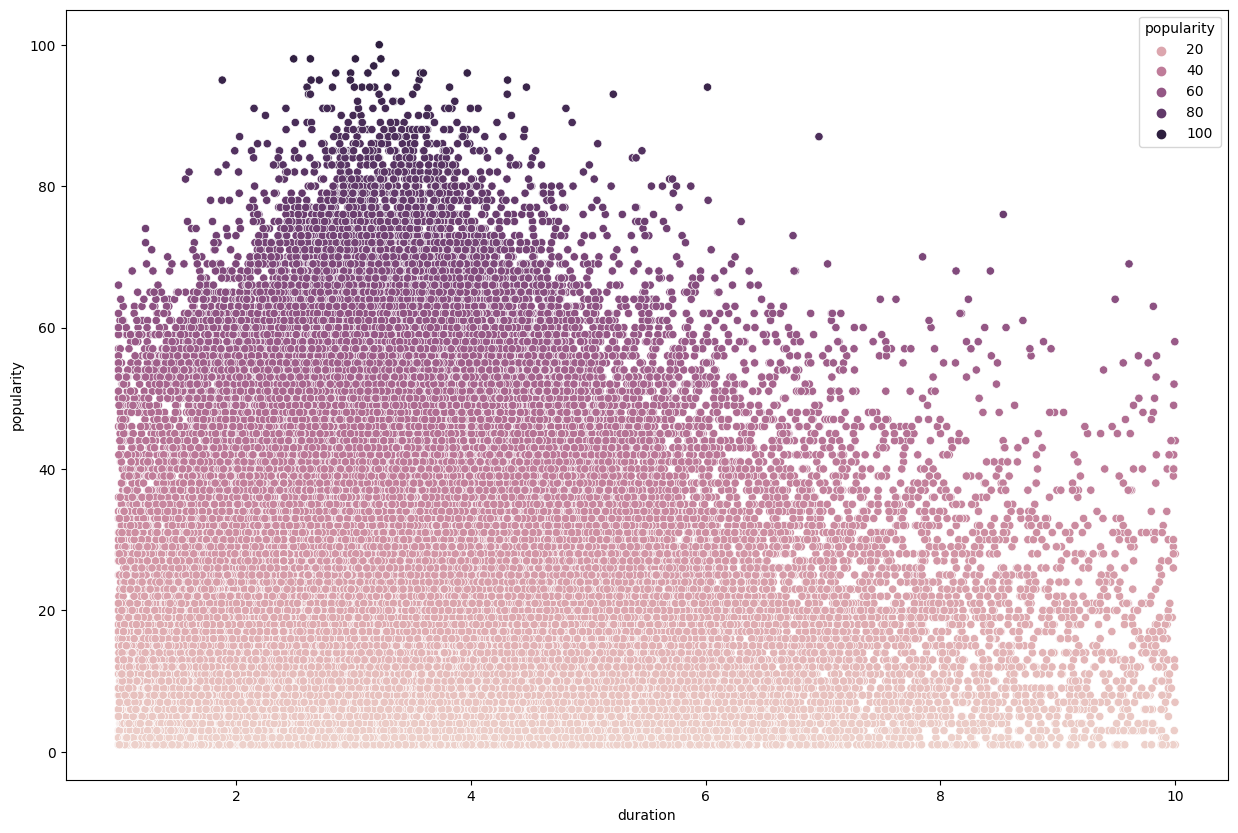

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=audiodf, x="duration_mins", y="popularity", hue="popularity"
)
plt.xlabel("duration")
plt.ylabel("popularity")

**Remark:**

Highly Popular Songs lies in the duration range of 2-4 minutes, this leds to an assumption that people tend to hear shorter songs have lower attention span when it comes to listening songs. We will be testing it under hypothesis testing in the later part.

*Top 5 songs based on all song features:*

In [ ]:
int_float_cols=audiodf.select_dtypes(include=['float64','int64']).columns.tolist()
for i in int_float_cols:
    display(audiodf.nlargest(5, [i])[['artist_name','track_name',i]])

,artist_name,track_name,acousticness
793,Frédéric Chopin,"Waltz in D-Flat Major, Op. 70 No. 3 (Ed. J. Fo...",0.996
800,Frédéric Chopin,"Sostenuto in E-Flat Major, Op. Posth., B. 133",0.996
1384,Johann Sebastian Bach,"Goldberg Variations, BWV 988: Var. 19",0.996
1406,Johann Sebastian Bach,"The Well-Tempered Clavier, Book 1: Prelude & F...",0.996
1431,Johann Sebastian Bach,"The Well-Tempered Clavier, Book 1: Prelude & F...",0.996


,artist_name,track_name,danceability
35107,Louie Zong,Tappy Toes,0.996
66729,The Real Triple D,Paper Plates,0.986
68964,TÂCHES,Familiar Feeling,0.986
82694,Jean Tonique,No Worries,0.986
129853,ITSOKTOCRY,"POP, LOCK & DROPDEAD",0.985


,artist_name,track_name,duration_mins
104094,deadmau5,Monophobia - Extended Mix,10.000000
15575,Richard Wagner,"Der fliegende Holländer, WWV 63, Act II: Summ ...",9.999550
29356,Tangerine Dream,Non-Locality Destination,9.999550
108558,Johann Sebastian Bach,"Ouverture [No. 2] in B Minor, BWV 1067: I. Ouv...",9.997400
119684,Bethel Music,Reckless Love (Spontaneous),9.995767


,artist_name,track_name,energy
20384,Rain for Deep Sleep,"Winter Rain (Loopable, No Fade)",1.0
33289,Rain for Deep Sleep,Rainforest Heavy Shower,1.0
33316,Spa,Rain Sound: Tropical Forest,1.0
35408,Ocean Sounds,Ocean Hypnosis,1.0
36926,Zen Music Garden,"White Noise Rain(Loopable,No fade)",1.0


,artist_name,track_name,instrumentalness
27532,Looped Fan Sleep Noise,Pink Noise Sleeping Baby (All Night Looped),1.0
29989,Spa,Rain Sound: Relaxing Sleep Music,1.0
44981,Straight_bluffing,Taul Tor,1.0
68390,Rain Sounds,Gentle Thunderstorm,1.0
71870,Smoothed Brown Noise,The Brown Noise,1.0


,artist_name,track_name,key
48,Betty Who,Friend Like Me,11
59,Dominion,Balenciaga,11
85,Rub!k,Breathe Deep (ASOT 874),11
136,ARTY,Must Be The Love (ASOT 874),11
153,Rakeem Miles,Hardway,11


,artist_name,track_name,liveness
10126,PJ Morton,First Began - Live,0.799
25039,Wasback,Rise Again (feat. Drew Ryn),0.799
32507,Matthew Margeson,Olivia & Lucas,0.799
40036,Mrs. GREEN APPLE,PARTY,0.799
46888,Sho Baraka,Drowning (Last Sorry),0.799


,artist_name,track_name,loudness
23628,araabMUZIK,Lalalala,1.187
69302,Mefjus,Together,0.738
40698,Subtronics,Thermal Expansion,0.681
91625,Jarvis,Ready 2 Party,0.679
8350,Duki,Rockstar,0.642


,artist_name,track_name,mode
0,YG,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",1
45,Burbank,Waiting for U,1
46,PJ Lucid,Martyr Luther King,1
48,Betty Who,Friend Like Me,1
49,Your Smith,The Spot,1


,artist_name,track_name,speechiness
56603,Robbioso,Life That I Live (feat. Lil Ant),0.659
69299,Mefjus,Fractured,0.659
71593,Trapandy,Smoking Dope with the Zombie Clique,0.659
77673,Amazon Sounds,Recordings of the Amazon,0.659
70554,Amazon Sounds,Bird Recordings,0.658


,artist_name,track_name,tempo
62979,Dj Cappo,Money Lift,248.321
116275,Hola Amigos,Mojo,246.055
11007,DRWN.,Libra,245.379
129458,Juan Rios,Capitano (Instrumental Version),245.327
5101,Hypnotize,Komakatapult - Instrumental,241.234


,artist_name,track_name,time_signature
47,Messiah,Bien De To,5
94,Xavier Wulf,A Day's Routine - Interlude,5
165,Ne-Yo,OCEAN SURE,5
463,I Do,Woke Up In Kingston,5
510,BluntOne,Ghost Train Haze,5


,artist_name,track_name,valence
6785,Paperfiends,Hear a Prayer for Em,1.000
38166,Paperfiends,Bro Bro Get Along,1.000
46670,Jim Rystron,Rickett's,1.000
93813,Pierce,Reality Resonance,1.000
46672,Jim Rystron,"Run, Johnny, Run",0.994


,artist_name,track_name,popularity
99354,Daddy Yankee,Con Calma,100
99325,Post Malone,Wow.,98
99327,Jonas Brothers,Sucker,98
99329,Billie Eilish,bad guy,98
123704,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,98


*Bottom 5 songs based on all song features:*

In [ ]:
int_float_cols=audiodf.select_dtypes(include=['float64','int64']).columns.tolist()
for i in int_float_cols:
    display(audiodf.nsmallest(5, [i])[['artist_name','track_name',i]])

,artist_name,track_name,acousticness
17147,The Tibia Band.,I Don't Wanna Be Discarded ( Rag Bag),0.0
28804,RichaadEB,Lunar Clock Luna Dial,0.0
38698,Gatecreeper,Daybreak,0.0
40455,DJ Duro Flex,What the Feel,0.0
41006,RichaadEB,Beloved Tomboyish Daughter,0.0


,artist_name,track_name,danceability
32083,Mammoth Grinder,Superior Firepower,0.0513
31029,Zeke,AR-15,0.0516
79388,Steven Halpern,Ruby Crystal 2.0,0.0533
76538,TakumaDemonReborn,School,0.0550
84166,Sounds of Thunder and Rain,Sounds of Thunder,0.0555


,artist_name,track_name,duration_mins
136,ARTY,Must Be The Love (ASOT 874),1.0
4774,David Chief,meditation,1.0
6109,Two Sleepy,untitled,1.0
18890,Ocean Sounds,Wave Sound 1 - Loopable With No Fade,1.0
29157,Ramsie,Happy Birthday Ramsie,1.0


,artist_name,track_name,energy
30309,Silent Knights,Brown Noise Fan,0.000020
75411,Steven Halpern,Practitioner's Bowl 2.0,0.000020
79388,Steven Halpern,Ruby Crystal 2.0,0.000032
77428,Steven Halpern,Egyptian Blue Infinity 2.0,0.000053
110448,Max Richter,A Blank Canvas,0.000091


,artist_name,track_name,instrumentalness
0,YG,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.0
2,R3HAB,Radio Silence,0.0
42,Orjan Nilsen,Nothing Here But Love,0.0
47,Messiah,Bien De To,0.0
52,Money Man,Bday Cake,0.0


,artist_name,track_name,key
55,Tabi Bonney,Faded,0
56,Trevor Hall,Free,0
77,ARTY,Sunrise (ASOT 874),0
90,Alex Sonata,I'll Be Your Light (ASOT 874),0
93,Andy Moor,There Is Light (ASOT 874) - A.R.D.I. Remix,0


,artist_name,track_name,liveness
68781,Ленинград,Не Париж 2,0.0113
27434,Black Caviar,Coco - Wuki Remix,0.0118
21807,Friendly Fires,Love Like Waves - Alex Metric Remix,0.0131
30587,Ленинград,Заебуль,0.0138
53137,Julius Dreisig,In My Head,0.0148


,artist_name,track_name,loudness
44979,Straight_bluffing,Got Last Dean,-55.909
44980,Straight_bluffing,Hunsum Best,-54.574
69233,Rain Sounds,Storms Brewing,-53.280
64675,Rain Sounds,English Countryside,-51.800
52767,Baby Sleep Lullaby Academy,A Storm Approaches,-50.735


,artist_name,track_name,mode
2,R3HAB,Radio Silence,0
41,Mr Little Jeans,Forgetter,0
42,Orjan Nilsen,Nothing Here But Love,0
47,Messiah,Bien De To,0
51,Dirty Projectors,Blue Bird,0


,artist_name,track_name,speechiness
22112,The Greatest Bits,Astral Alley,0.0221
104093,José Pardial,Mañana,0.0224
89119,Adam Ackerman,Don't Worry About Me,0.0225
115374,Fleetwood Mac,Love Shines - Remastered,0.0226
114567,Eagles,Do Something,0.0227


,artist_name,track_name,tempo
39321,Dog Music,Amazing Dog Music,31.847
10603,The Album Leaf,Bottom of the Lake,32.001
65909,The Venus Project,Moon to Moon,32.095
62958,Sparkles of Fantasy,Fate in Love,33.003
64274,Sparkles of Fantasy,Wet Forest,33.108


,artist_name,track_name,time_signature
208,Twice 20,Fallin' - GET FAR Remix,1
298,Prelow,Some Nights,1
351,Johann Sebastian Bach,"Keyboard Concerto in D Minor, BWV 1059 (Arr. D...",1
768,Grupo Codiciado,El Jacal,1
784,Frédéric Chopin,"3 Grandes valses brillantes, Op. 34: No. 1 in ...",1


,artist_name,track_name,valence
69422,Daniel Pemberton,Molly's Dream,0.0
73400,dné,School,0.0
75411,Steven Halpern,Practitioner's Bowl 2.0,0.0
81542,dné,Work,0.0
86097,Rain Sound Studio,Bedtime Rain Recording,0.0


,artist_name,track_name,popularity
171,Chris Lane,Number One,1
252,Joe,Red Planet - Red Planet Extended,1
258,Young Fredo,Keep It Real,1
263,James Horner,"Jake's First Flight (From ""Avatar"")",1
276,RVSSLL,Tech House Rewind - JackEL Remix,1


**Quick Multi-collinearity Check:**

In [ ]:
# Define the variables except target
X = audiodf.iloc[:, 3:-1]
y = audiodf[['popularity']]


# Calculate VIF for independent variables
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

             feature        VIF
0       acousticness   4.195411
1       danceability  16.119820
2      duration_mins   9.062237
3             energy  19.294709
4   instrumentalness   2.059077
5                key   3.169078
6           liveness   2.941235
7           loudness   9.700250
8               mode   2.604339
9        speechiness   2.243469
10             tempo  16.335324
11    time_signature  49.710719
12           valence   5.675785


**Insights:**

1. *Multicollinearity* is significant in the data.
2. *Danceability, energy , tempo* and *time signature* have high VIF values which needs to be treated.

## Feature Engineering##

In [ ]:
songs_grp = audiodf.groupby(["artist_name"])["track_id"].count().reset_index()
songs_grp = songs_grp.rename({'track_id':'total_songs_by_artist'}, axis = 'columns')

songs_grp['is_new_artist'] = np.where(songs_grp['total_songs_by_artist']==1,1,0)
audiodf = audiodf.merge(songs_grp, on = ['artist_name'], how = 'left')

audiodf['popular_key'] = np.where(audiodf['key'].isin([0.0, 1.0, 8.0, 11.0]), 1, 0) 

# Difference of accousticness and energy gives us noise levels.
audiodf['noise_level'] = (audiodf['energy'] - audiodf['acousticness']) / 2

**Checking Multi-collinearity after Feature Engineering:**

In [ ]:
X = audiodf[['duration_mins', 'instrumentalness', 
             'liveness', 'mode',
             'speechiness', 'tempo', 
             'valence','total_songs_by_artist', 
             'is_new_artist', 'popular_key', 
             'noise_level']]

y = audiodf[['popularity']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

                  feature        VIF
0           duration_mins   6.797703
1        instrumentalness   1.566910
2                liveness   2.694030
3                    mode   2.508142
4             speechiness   2.036758
5                   tempo  10.628822
6                 valence   3.982557
7   total_songs_by_artist   1.277582
8           is_new_artist   1.196649
9             popular_key   1.619016
10            noise_level   1.685131


##Data Cleaning##

### Drop rows or columns based on EDA

1. Based on Correlation Plot, Remove Loudness Variable

2. Drop track_names which has certain keywords pertaining to non-music tracks

3. Convert tempo variable into a categorical value where

Tempo less than 76 maps to -1 (Slow-tempo), Tempo between 76 and 120 maps to 0 (Medium-tempo), Tempo less than 76 maps to 1 (Up-tempo)

In [ ]:
## Remove loudness variable as it is highly correlated with certain other input variables

class Data_Cleaning_SP(object):
  def __init__(self, data =None, drop_columns=None, keywords=None, case_sensitive=False, is_cat_required=False, col_to_categorize=None, cat_low_cut_off=0.5, cat_high_cut_off=0.5):
    self.data = data
    self.drop_columns = drop_columns
    self.keywords = keywords
    self.case_sensitive = case_sensitive
    self.is_cat_required = is_cat_required
    self.col_to_categorize = col_to_categorize
    self.cat_low_cut_off = cat_low_cut_off
    self.cat_high_cut_off = cat_high_cut_off

  def drop_columns_from_df(self, drop_columns):
    """
    This function takes specific columns that we would like to drop out of our dataframe
    input: a column OR a list of columns
    output: the modified dataframe
    """
    if self.drop_columns:
      print("\n1. Drop columns engine started")
      
      if isinstance(drop_columns, list):
        print(f"\n Dropping columns: {','.join(drop_columns)}")
        self.data = self.data.drop(columns = drop_columns)
      
      elif isinstance(drop_columns, str):
        print(f"\n Dropping column {drop_columns}")
        self.data = self.data.drop(columns = drop_columns)
      
      print("\Column(s) Dropped")

    return self.data
  

  def regex_track_removal(self,keywords,case_sensitive):
    """
    This function takes specific keywords based on which we would like to drop certain track_names out of our dataframe
    input   : a regex-type input string
    output  : the modified dataframe
    """
    if self.keywords:
      print("\n2. Track_name removal based on regex started")
      if self.case_sensitive:
        _remove_ids = self.data[
                            self.data.track_name.str.contains(
                                pat = self.keywords,
                                regex = True
                                )
                           ].index
      else:
        _remove_ids = self.data[
                              self.data.track_name.str.contains(
                                  pat = self.keywords,
                                  flags = re.IGNORECASE,
                                  regex = True
                                  )
                             ].index
      self.data = self.data.drop(index = _remove_ids)
      print("\nTrack_name removal based on regex done")

    return self.data

  def column_categorize(self, is_cat_required, col_to_categorize, cat_low_cut_off, cat_high_cut_off):
    """
    Categorize a column into a categorical variable based on provided cutoff
    """
    if is_cat_required and cat_low_cut_off and cat_high_cut_off:
      print(f"\n3. Column categorication for {col_to_categorize} started")
      
      # self.data[col_to_categorize] = np.where(self.data[col_to_categorize]<cat_cut_off, 1, 0)
      self.data.loc[self.data[col_to_categorize].between(0, cat_low_cut_off-1), col_to_categorize] = -1
      self.data.loc[self.data[col_to_categorize].between(cat_low_cut_off, cat_high_cut_off), col_to_categorize] = 0
      self.data.loc[self.data[col_to_categorize] > cat_high_cut_off, col_to_categorize] = 1
      print(f"\n Column categorication for {col_to_categorize} done")
    
    return self.data

  def runner(self):
    print("=====Data Cleaning Pipeline started====")
    print("Dropping given list of columns")
    
    self.data = self.drop_columns_from_df(self.drop_columns)
    
    print("Regex removal from track name")
    self.data = self.regex_track_removal(self.keywords,self.case_sensitive)
    
    print("Applying column binning on given colums")
    self.data = self.column_categorize(self.is_cat_required, self.col_to_categorize, self.cat_low_cut_off, self.cat_high_cut_off)
    
    print("\n=====Data Cleaning Pipeline done====")
    
    return self.data  

### Run the Data Cleaning Module on our dataframe to prepare the data for analysis###

In [ ]:
audiodf = Data_Cleaning_SP(
data = audiodf,
drop_columns = ['loudness', 'danceability', 'time_signature', 'key', 'acousticness', 'energy'],
keywords = 'mix|rain|podcast|intro|outro|DJ|sleep',
case_sensitive = False,
is_cat_required = True,
col_to_categorize = 'tempo',
cat_low_cut_off = 76,
cat_high_cut_off = 120,
).runner()

=====Data Cleaning Pipeline started====
Dropping given list of columns

1. Drop columns engine started

 Dropping columns: loudness,danceability,time_signature,key,acousticness,energy
\Column(s) Dropped
Regex removal from track name

2. Track_name removal based on regex started

Track_name removal based on regex done
Applying column binning on given colums

3. Column categorication for tempo started

 Column categorication for tempo done

=====Data Cleaning Pipeline done====


###Checking Multi-collinearity after Feature Engineering + Data Cleaning:###

In [ ]:
X = audiodf[['duration_mins', 'instrumentalness', 
             'liveness', 'mode',
             'speechiness', 'tempo', 
             'valence','total_songs_by_artist', 
             'is_new_artist', 'popular_key', 
             'noise_level']]

y = audiodf[['popularity']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

                  feature       VIF
0           duration_mins  4.639523
1        instrumentalness  1.497975
2                liveness  2.642208
3                    mode  2.445315
4             speechiness  1.922700
5                   tempo  1.024701
6                 valence  3.462092
7   total_songs_by_artist  1.288535
8           is_new_artist  1.194399
9             popular_key  1.601369
10            noise_level  1.646251


Now Data has been cleaned, now lets deep dive to Modelling.

##Modelling##

In [ ]:
# Define X(input) and y(target) sets
X = audiodf[['duration_mins', 'instrumentalness', 
             'liveness', 'mode',
             'speechiness', 'tempo', 
             'valence','total_songs_by_artist', 
             'is_new_artist', 'popular_key', 
             'noise_level']].copy()
X['duration_mins'] = np.log(X['duration_mins'])
#X['key'] = np.log(X['key'])
y = audiodf[['popularity']]

###Vanilla OLS model###

In [ ]:
#X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
res = model.resid
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:             popularity   R-squared (uncentered):                   0.694
Model:                            OLS   Adj. R-squared (uncentered):              0.694
Method:                 Least Squares   F-statistic:                          2.027e+04
Date:                Sat, 20 May 2023   Prob (F-statistic):                        0.00
Time:                        13:03:30   Log-Likelihood:                     -4.2924e+05
No. Observations:               98446   AIC:                                  8.585e+05
Df Residuals:                   98435   BIC:                                  8.586e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

###Check Q-Q plot for Normality###

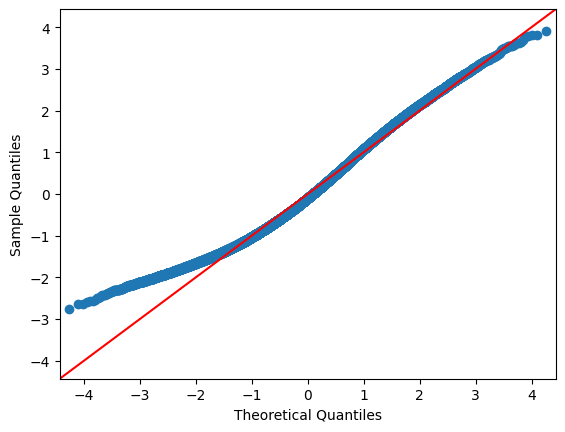

In [ ]:
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

###OLS with log transformations on the y variable###

In [ ]:
#X = sm.add_constant(X)
model = sm.OLS(np.log(y), X).fit()
res = model.resid
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:             popularity   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                          6.497e+04
Date:                Sat, 20 May 2023   Prob (F-statistic):                        0.00
Time:                        13:05:09   Log-Likelihood:                     -1.4989e+05
No. Observations:               98446   AIC:                                  2.998e+05
Df Residuals:                   98435   BIC:                                  2.999e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

###Check Q-Q plot for Normality with Log transformed Y###

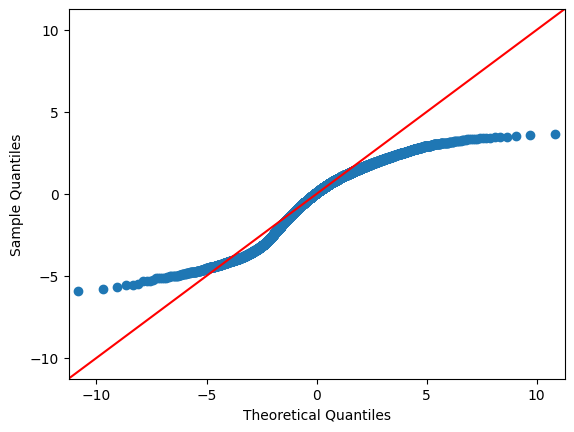

In [ ]:
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

###Insights:###

The qq plot became even more distorted. Hence lets try box cox transformation:

###OLS with Box-Cox transformation on the y variable.###

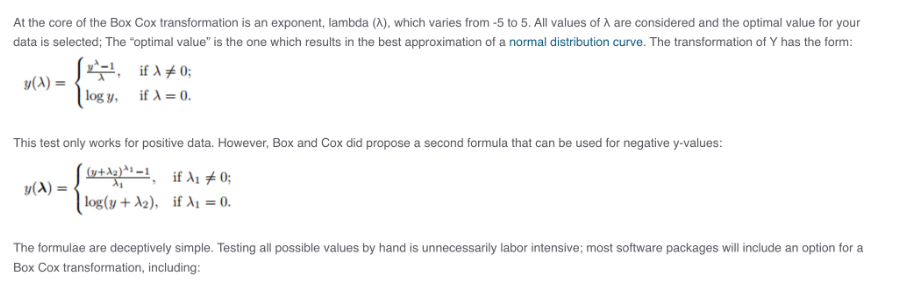

In [ ]:
# Applying box-cox transformation
yt, _ = stats.boxcox(y['popularity'].values)
model = sm.OLS(yt, X).fit()
res = model.resid
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.789
Model:                            OLS   Adj. R-squared (uncentered):              0.789
Method:                 Least Squares   F-statistic:                          3.356e+04
Date:                Sat, 20 May 2023   Prob (F-statistic):                        0.00
Time:                        13:06:58   Log-Likelihood:                     -2.8861e+05
No. Observations:               98446   AIC:                                  5.772e+05
Df Residuals:                   98435   BIC:                                  5.773e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

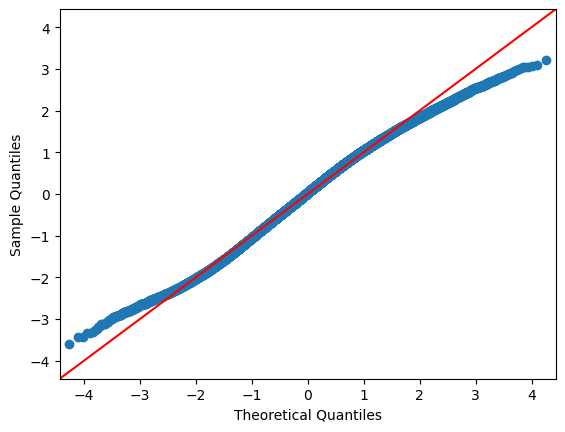

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.figure()
plt.show()

###What Fits the data wll adhering all Assumptions lets compare###


Remarks from above experiments:

We see from the above results, that we get the best results for the OLS with box-cox transformation on y variable gives us the best normality on Q-Q plot, and we will use the same model to test for RMSE on our test set

**TRAIN-TEST SPLIT**

In [56]:
X_train, X_test,y_train, y_test = train_test_split(
    X, yt , test_size=0.15, random_state=1000)

**Model Check Performance**

In [57]:
model = sm.OLS(y_train, X_train).fit()
res = model.resid
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.789
Model:                            OLS   Adj. R-squared (uncentered):              0.789
Method:                 Least Squares   F-statistic:                          2.852e+04
Date:                Sat, 20 May 2023   Prob (F-statistic):                        0.00
Time:                        13:14:47   Log-Likelihood:                     -2.4538e+05
No. Observations:               83679   AIC:                                  4.908e+05
Df Residuals:                   83668   BIC:                                  4.909e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

##Hypothesis Testing##

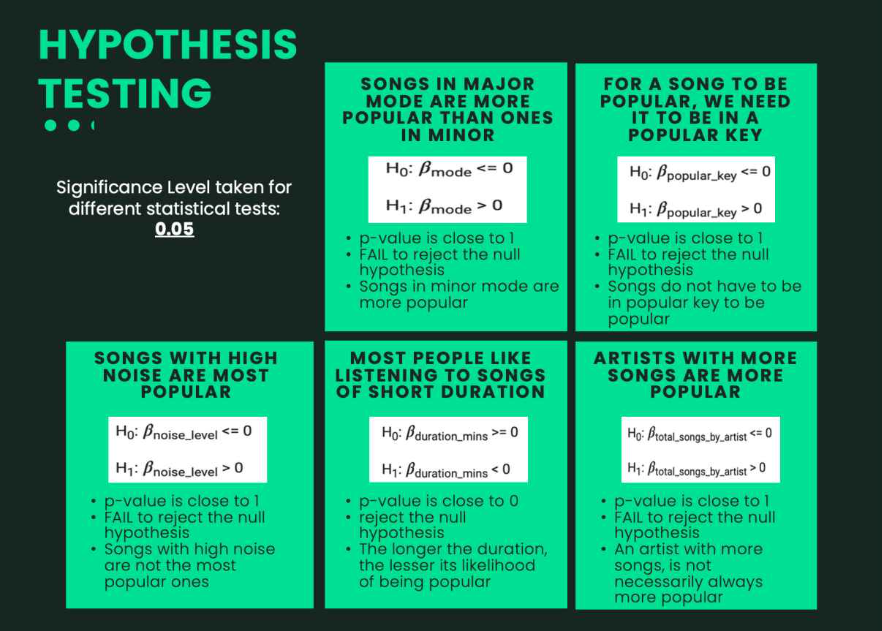

###Miscellaneous Modelling###

### Random Forest##

In [58]:
X_train, X_test,y_train, y_test = train_test_split(
    X, yt , test_size=0.15, random_state=1000)

rf_model = RandomForestRegressor(max_depth=2, random_state=0)

rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [59]:
y_hat = rf_model.predict(X_test)
mean_squared_error(y_test, y_hat, squared=False)

4.051562574457835

###Vanilla Cat Boost###

In [60]:
cat_model = CatBoostRegressor(loss_function='RMSE',
                           verbose=True)

cat_model.fit(X_train, y_train)

Learning rate set to 0.082405
0:	learn: 4.2580938	total: 110ms	remaining: 1m 50s
1:	learn: 4.2197533	total: 160ms	remaining: 1m 19s
2:	learn: 4.1839829	total: 208ms	remaining: 1m 9s
3:	learn: 4.1513679	total: 262ms	remaining: 1m 5s
4:	learn: 4.1241647	total: 306ms	remaining: 1m
5:	learn: 4.1000836	total: 355ms	remaining: 58.8s
6:	learn: 4.0793378	total: 407ms	remaining: 57.8s
7:	learn: 4.0619869	total: 461ms	remaining: 57.2s
8:	learn: 4.0464333	total: 513ms	remaining: 56.4s
9:	learn: 4.0323077	total: 563ms	remaining: 55.8s
10:	learn: 4.0200304	total: 594ms	remaining: 53.4s
11:	learn: 4.0100704	total: 628ms	remaining: 51.7s
12:	learn: 4.0001721	total: 662ms	remaining: 50.2s
13:	learn: 3.9902062	total: 723ms	remaining: 50.9s
14:	learn: 3.9829064	total: 766ms	remaining: 50.3s
15:	learn: 3.9752601	total: 811ms	remaining: 49.9s
16:	learn: 3.9687689	total: 865ms	remaining: 50s
17:	learn: 3.9624041	total: 924ms	remaining: 50.4s
18:	learn: 3.9560957	total: 980ms	remaining: 50.6s
19:	learn: 3.9

###Modeling Performance Improvements###
# 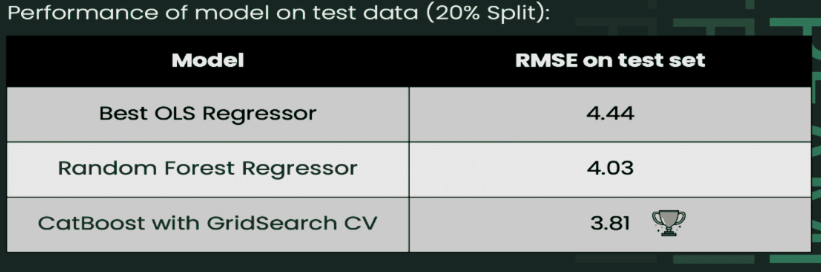

##Observations, Future Scope##

**Observation:**

Cat Boost is the champion model based on RMSE however, explainability is lost as the predictor is a black box function.

1. Get more samples of data
2. Gather more variables which help explain the data better such as Genre, Recent track popularity
3. Playlists for the track
4. NLP to leverage information out of track name and lyrics
5. Audio processing to get more features out of the audio data
6. We could make use of popularity of featured artists
